In [1]:
!git clone -b brian-etl-code https://github.com/The-Taimaka-Project/health-predictions.git
#!git clone https://github.com/The-Taimaka-Project/health-predictions.git

Cloning into 'health-predictions'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 728 (delta 86), reused 43 (delta 43), pack-reused 621 (from 1)
Receiving objects: 100% (728/728), 8.56 MiB | 6.24 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [9]:
!pip install boto3 --quiet
!pip install autogluon --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:0

In [10]:
import sys
sys.path.append('/content/health-predictions/packages/inference/run')
#import util
#import globals
#import digitalocean

In [ ]:
from globals import logger,MODEL_DIR, ETL_DIR
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from util import strip_column_names,DetnReaderWriter,split_detn_new_onset_medical_complication,drop_result_columns,drop_recent_columns,drop_columns_muac
from util import ag_feature_generator,lightgbm_train,select_features
import matplotlib.pyplot as plt
from warnings import simplefilter
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
from digitalocean import DigitalOceanStorage


In [11]:
import os
from google.colab import userdata
os.environ["TAIMAKA_DO_ACCESS_KEY"] = userdata.get('TAIMAKA_DO_ACCESS_KEY')
os.environ["TAIMAKA_DO_SECRET_KEY"] = userdata.get('TAIMAKA_DO_SECRET_KEY')

do_storage = DigitalOceanStorage()

In [15]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)
simplefilter(action="ignore", category=RuntimeWarning)

# get the data

In [25]:
detn_reader = DetnReaderWriter()
detn,label = detn_reader.read_new_onset_medical_complication()


[0.76207775]
[0.65541519]


/content/health-predictions/packages/inference/run/util.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  detn['wk1_calc_los'].fillna(0,inplace=True)


In [27]:
detn_admit_only,_,_,_ = split_detn_new_onset_medical_complication(detn,label)
pid_not_in_admit = detn[~detn['pid'].isin(detn_admit_only['pid'])]['pid']

# Get rows from detn where 'pid' is in pid_not_in_admit
detn_filtered = detn[detn['pid'].isin(pid_not_in_admit)].copy()


(433, 550) (424, 1450) (421, 1897) (954, 2344)


In [48]:
def drop_features(detn_filtered,label):
  all_columns = set(detn_filtered.columns)
  print(detn_filtered[label].mean(),detn_filtered[label].sum(),detn_filtered.shape)
  detn_filtered = drop_result_columns(detn_filtered,label)
  print(detn_filtered[label].mean(),detn_filtered[label].sum(),detn_filtered.shape)
  result_columns = all_columns - set(detn_filtered.columns)

  all_columns = set(detn_filtered.columns)
  drop_recent_columns(detn_filtered)
  print(detn_filtered[label].mean(),detn_filtered[label].sum(),detn_filtered.shape)
  recent_columns = all_columns - set(detn_filtered.columns)

  all_columns = set(detn_filtered.columns)
  drop_columns_muac(detn_filtered,drop_muac=False,drop_weight=False,drop_height=False)
  print(detn_filtered[label].mean(),detn_filtered[label].sum(),detn_filtered.shape)
  reverse_causal_columns = all_columns - set(detn_filtered.columns)


  return detn_filtered,result_columns,recent_columns,reverse_causal_columns



In [49]:
detn_admit_only,result_columns,recent_columns,reverse_causal_columns = drop_features(detn_admit_only,label)

detn_filtered,result_columns,recent_columns,reverse_causal_columns = drop_features(detn_filtered,label)

0.6096997690531177 264 (433, 511)
0.6096997690531177 264 (433, 511)
0.6096997690531177 264 (433, 511)
0.6096997690531177 264 (433, 425)
0.43746525847693163 787 (1799, 1998)
0.43746525847693163 787 (1799, 1998)
0.43746525847693163 787 (1799, 1998)
0.43746525847693163 787 (1799, 1718)


In [50]:

y_cat1_cols = [col for col in detn.columns if col.startswith('y_')]
y_cols = y_cat1_cols.copy()
y_cols.append(label)


# LightGBM iteration for feature selection

In [52]:
# prompt: train test split admit_raw using column y_detn_ever as y
# Separate features (X) and target (y)

#X = detn_admit_only.drop(columns=y_cols)
#y = detn_admit_only[label]

#X = detn.drop(columns=y_cols)
X = detn_filtered.drop(columns=y_cols)
y = detn_filtered[label]


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(1439, 1703) (360, 1703) (1439,) (360,)


In [55]:
X_train_transformed,X_test_transformed = ag_feature_generator(X_train,X_test)
transformed = pd.concat([X_train_transformed.join(y_train),X_test_transformed.join(y_test)],axis=0)

In [57]:
gbm,f1_scored,aic,top_features = lightgbm_train(X_train_transformed, X_test_transformed, y_train, y_test)
#gbm,f1_scored,aic,top_features = lightgbm_train(X_train, X_test, y_train, y_test)
print(len(gbm.feature_name_),f1_scored)

X_train_transformed_top = X_train_transformed[top_features].copy()
#X_train_transformed_top = X_train[top_features].copy()
X_test_transformed_top = X_test_transformed[top_features].copy()
#X_test_transformed_top = X_test[top_features].copy()
gbm,f1_scored,aic,top_features = lightgbm_train(X_train_transformed_top, X_test_transformed_top, y_train, y_test)
print(len(gbm.feature_name_),f1_scored)

best_gbm,best_features,results_df,best_aic,features = select_features(gbm,X_train_transformed_top,X_test_transformed_top, y_train, y_test,30,0,-1)

808 0.9034267912772586
268 0.9192546583850931


In [58]:
print(best_aic,'\n',best_features,len(best_features))
results_df.sort_values(by='AIC',ascending=True)

217.28072959503265 
 ['wfh_rsquared' 'cg_weight' 'wfh_trend' 'hl_trend' 'weekly_avg_muac'
 'admit_cat1_complications' 'wk2_wfaz' 'wfhz_admit' 'wk3_wfhz'
 'wk1_resp_rate_weekly' 'weight_rsquared' 'hfa_trend' 'wk3_hfa_diff_rate'
 'household_adults_slept_living_children_z' 'weight_trend' 'wk2_wfhz'
 'wk1_rainy_season_weekly' 'hfa_rsquared' 'temperature'] 19


,f1_score,AIC,num_features
11,0.899083,217.280730,19
9,0.894410,217.537068,21
6,0.891641,220.016880,24
7,0.901840,222.123507,23
10,0.882716,226.055112,20
8,0.886154,226.241301,22
3,0.903427,228.812482,27
2,0.893750,229.160299,28
5,0.896552,233.023180,25
4,0.881988,238.225133,26


In [60]:
N_FEATURES = 13
print(N_FEATURES,features[N_FEATURES])


top_features = [col for col in strip_column_names(features[N_FEATURES]) if col in detn.columns]


13 ['wfh_rsquared' 'hl_trend' 'household_adults_slept_living_children_z'
 'wk1_resp_rate_weekly' 'wk3_wfhz' 'cg_weight' 'wk2_wfhz' 'wk2_wfaz'
 'wfh_trend' 'weight_trend' 'wfhz_admit' 'hfa_rsquared' 'weekly_avg_muac']


In [62]:
top_features = ['hl_trend', 'weekly_avg_muac', 'wk2_muac', 'estdist_home', 'wk1_rainy_season_weekly', 'resp_rate', 'muac_trend', 'cat1_complications_weekly', 'household_adults_slept_living_children_z', 'muac_diff_ratio_z', 'muac_rsquared', 'muac_diff_ratio_rate', 'wk1_weight_diff_rate', 'wk1_resp_rate_weekly']

# AutoGluon Training

In [63]:
# prompt: train test split admit_raw using column y_detn_ever as y

# Separate features (X) and target (y)

#X = detn_admit_only[top_features]
#y = detn_admit_only[label]

X = detn_filtered[top_features]
y = detn_filtered[label]
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43) # Adjust test_size and random_state as needed

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1349, 14) (450, 14) (1349,) (450,)


In [64]:
AG_PATH = f'AutogluonModels/{label}'
train_data = TabularDataset(X_train.join(y_train))
predictor = TabularPredictor(label=label,eval_metric='f1',path=AG_PATH).fit(train_data,time_limit=300,presets='medium_quality')


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       10.86 GB / 12.67 GB (85.7%)
Disk Space Avail:   65.16 GB / 107.72 GB (60.5%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/content/AutogluonModels/new_onset_medical_complication"
Train Data Rows:    1349
Train Data Columns: 14
Label Column:       new_onset_medical_complication
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [np.int64(1), np.int64(0)]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'r

## evaluate AG model on holdout (i.e., test) data

In [66]:
test_data2 = TabularDataset(X_test.join(y_test))
predictor.calibrate_decision_threshold()
y_pred = predictor.predict(test_data2.drop(columns=[label]))
print(predictor.evaluate(test_data2, silent=True))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print(f1_score(y_test,y_pred))


Calibrating decision threshold to optimize metric f1 | Checking 51 thresholds...
Calibrating decision threshold via fine-grained search | Checking 38 thresholds...
	Base Threshold: 0.500	| val: 0.8333
	Best Threshold: 0.491	| val: 0.8347


{'f1': 0.8758782201405152, 'accuracy': 0.8822222222222222, 'balanced_accuracy': np.float64(0.8830530683555362), 'mcc': np.float64(0.7645367503585571), 'roc_auc': np.float64(0.944529373225595), 'precision': 0.8577981651376146, 'recall': 0.8947368421052632}
Confusion Matrix:
[[210  31]
 [ 22 187]]
0.8758782201405152


## feature importance

Computing feature importance via permutation shuffling for 14 features using 450 rows with 10 shuffle sets... Time limit: 400s...
	5.22s	= Expected runtime (0.52s per shuffle set)
	1.75s	= Actual runtime (Completed 10 of 10 shuffle sets)


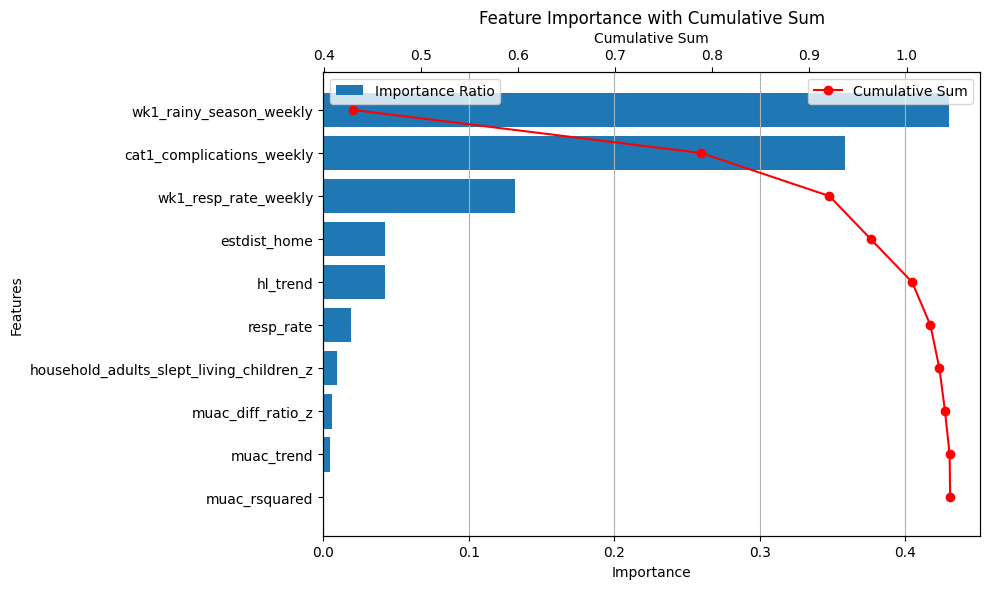

In [72]:
autogluon_feature_importance = predictor.feature_importance(test_data2,subsample_size=1000,time_limit=400)
autogluon_feature_importance['cumsum'] = autogluon_feature_importance['importance'].cumsum()/autogluon_feature_importance['importance'].sum()
autogluon_feature_importance['importance_ratio'] = autogluon_feature_importance['importance']/autogluon_feature_importance['importance'].sum()
autogluon_feature_importance[['cumsum','importance_ratio']]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot on the primary y-axis
autogluon_feature_importance_filtered = autogluon_feature_importance[autogluon_feature_importance['importance']>0]
ax1.barh(autogluon_feature_importance_filtered.index, autogluon_feature_importance_filtered['importance_ratio'], label='Importance Ratio')
ax1.set_xlabel('Importance')
ax1.set_ylabel('Features')
ax1.set_title('Feature Importance with Cumulative Sum')
ax1.legend(loc='upper left') # specify location for the first legend
ax1.grid(True, axis='x') # gridlines only on the x-axis for the bar plot
ax1.invert_yaxis()

# Create a secondary y-axis
ax2 = ax1.twiny()

# Line plot on the secondary y-axis
ax2.plot(autogluon_feature_importance_filtered['cumsum'], autogluon_feature_importance_filtered.index, marker='o', linestyle='-', color='red', label='Cumulative Sum')
ax2.set_xlabel('Cumulative Sum')
ax2.legend(loc='upper right') # specify location for the second legend

# Improve layout
fig.tight_layout()
plt.show()


In [74]:
# prompt: get index values of autogluon_feature_importance.sort_values(by='importance',ascending=False)

autogluon_feature_importance.sort_values(by='importance',ascending=False).index.tolist()

['wk1_rainy_season_weekly',
 'cat1_complications_weekly',
 'wk1_resp_rate_weekly',
 'estdist_home',
 'hl_trend',
 'resp_rate',
 'household_adults_slept_living_children_z',
 'muac_diff_ratio_z',
 'muac_trend',
 'muac_rsquared',
 'muac_diff_ratio_rate',
 'weekly_avg_muac',
 'wk1_weight_diff_rate',
 'wk2_muac']

## export the AG model

In [89]:
VERSION = "0.1.0"

metadata = {
    "version": VERSION,
    "inputs": autogluon_feature_importance.sort_values(by='importance',ascending=False).index.tolist(),
    "outputs": "chance of new onset medical complication, referral to inpatient treatment with a cat1 medical severity",
    "description": (
        "Predicts chance of new onset medical complication health complication  given the latest 3 weeks of patient weekly (raw and processed) data plus their admission data.  Medical complication is defined as a 'cat1' complication (see vars in raw ODK data with cat1_ prefix)"
    ),
    "feature_engineering": (
        "<household_adults_slept_living_children_z> is a one-dimension PCA reduction of the normalized values of ['household_adults','household_slept','living_children'] <muac_diff_ratio_z> is a similar reduction of ['muac_diff_ratio','muac'] which are muac change per day over the patient's treatment ((latest muac - first muac)/days in program) and their admittance muac"
    ),
    "contact": "Brian Chaplin",
}

path = f"{MODEL_DIR}{label}not1/{VERSION}/model.tar.gz"

do_storage.to_autogluon_tarball(predictor, model_metadata=metadata, path=path)



TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/AutogluonModels/new_onset_medical_complication")
